## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from pythainlp.corpus.common import thai_stopwords
from pythainlp import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import re

## Import Data

In [2]:
df_train = pd.read_parquet('train-00000-of-00001.parquet') 

In [3]:
df_train.head()

,texts,category
0,ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกร...,1
1,เปิดศักราชใหม่! นายกฯ แถลงข่าวก่อนการแข่งขันศึ...,1
2,บัตรสมาชิกลดได้อีกไหมคับ,1
3,สนใจ new mazda2ครับ,1
4,😍😍,0


In [4]:
df_train['category'].value_counts()

category
1    11795
2     5491
0     3866
3      476
Name: count, dtype: int64

In [5]:
df_train.shape

(21628, 2)

In [6]:
df_val = pd.read_parquet('validation-00000-of-00001.parquet')

In [7]:
df_val.head()

,texts,category
0,วันที่6/3/61 เสียอารมณ์มาเร้ย. อาหารช้ามากกกกก...,2
1,ยี่ห้อนี่ เขาชอบตั้งชื่อ ลงท้ายด้วย สระอา เทีย...,0
2,สองวันสุดท้าย! ใครอยู่แถวแฟชั่น ไอส์แลนด์ มาร่...,1
3,น้องแสงโสมอี้บ๋อ กะว่าน้องโซดา น้ำแข็งดี เอ๊ะห...,0
4,สนามบินไหนไม่แพงล่ะครับบ ชางฮี เชคแลบก๊ก เจเอฟ...,1


In [8]:
df_val['category'].value_counts()

category
1    1291
2     637
0     434
3      42
Name: count, dtype: int64

In [9]:
df_val.shape

(2404, 2)

In [10]:
df_test = pd.read_parquet('test-00000-of-00001.parquet') 

In [11]:
df_test.head()

,texts,category
0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...,2
1,ครับ #phithanbkk,1
2,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...,2
3,Cf clarins 5 ขวด 2850,1
4,ทานได้ค่ะ น้ำซุป MK ต้มมาจากหัวผักกาด ซีอิ้วขา...,1


In [12]:
df_test['category'].value_counts()

category
1    1453
2     683
0     478
3      57
Name: count, dtype: int64

In [13]:
df_test.shape

(2671, 2)

## EDA

In [14]:
df_train['text_length'] = df_train['texts'].apply(len)

In [15]:
df_val['text_length'] = df_val['texts'].apply(len)

In [16]:
df_test['text_length'] = df_test['texts'].apply(len)

In [17]:
df_train.head()

,texts,category,text_length
0,ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกร...,1,162
1,เปิดศักราชใหม่! นายกฯ แถลงข่าวก่อนการแข่งขันศึ...,1,75
2,บัตรสมาชิกลดได้อีกไหมคับ,1,24
3,สนใจ new mazda2ครับ,1,19
4,😍😍,0,2


In [18]:
df_val.head()

,texts,category,text_length
0,วันที่6/3/61 เสียอารมณ์มาเร้ย. อาหารช้ามากกกกก...,2,147
1,ยี่ห้อนี่ เขาชอบตั้งชื่อ ลงท้ายด้วย สระอา เทีย...,0,93
2,สองวันสุดท้าย! ใครอยู่แถวแฟชั่น ไอส์แลนด์ มาร่...,1,371
3,น้องแสงโสมอี้บ๋อ กะว่าน้องโซดา น้ำแข็งดี เอ๊ะห...,0,85
4,สนามบินไหนไม่แพงล่ะครับบ ชางฮี เชคแลบก๊ก เจเอฟ...,1,555


In [19]:
df_test.head()

,texts,category,text_length
0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...,2,51
1,ครับ #phithanbkk,1,16
2,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...,2,82
3,Cf clarins 5 ขวด 2850,1,21
4,ทานได้ค่ะ น้ำซุป MK ต้มมาจากหัวผักกาด ซีอิ้วขา...,1,65


In [20]:
df_train['text_length'].describe()

count    21628.000000
mean        89.818291
std        149.255596
min          1.000000
25%         19.000000
50%         39.000000
75%         98.000000
max       1997.000000
Name: text_length, dtype: float64

In [21]:
df_val['text_length'].describe()

count    2404.000000
mean       89.504160
std       142.416416
min         1.000000
25%        19.000000
50%        41.000000
75%        99.000000
max      1708.000000
Name: text_length, dtype: float64

In [22]:
df_test['text_length'].describe()

count    2671.000000
mean       90.363534
std       152.053201
min         1.000000
25%        19.000000
50%        39.000000
75%        98.000000
max      1978.000000
Name: text_length, dtype: float64

Use FacetGrid from the seaborn library to create a grid of histograms of text length based on their category

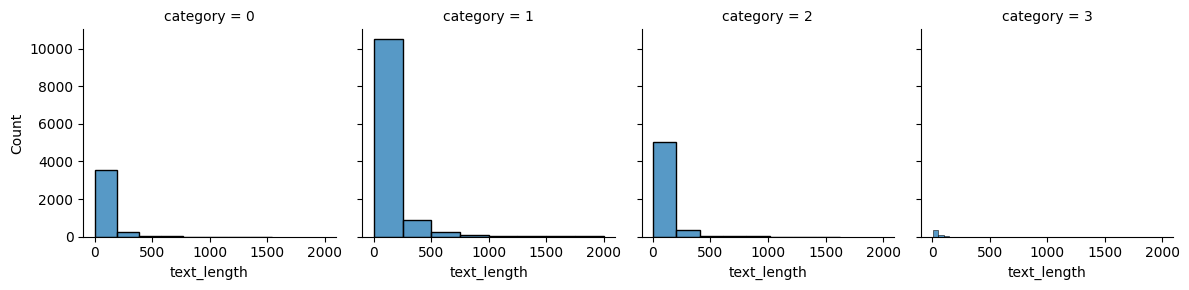

In [23]:
g = sns.FacetGrid(df_train,col='category')
g.map_dataframe(sns.histplot,x='text_length',bins=8)
plt.show()

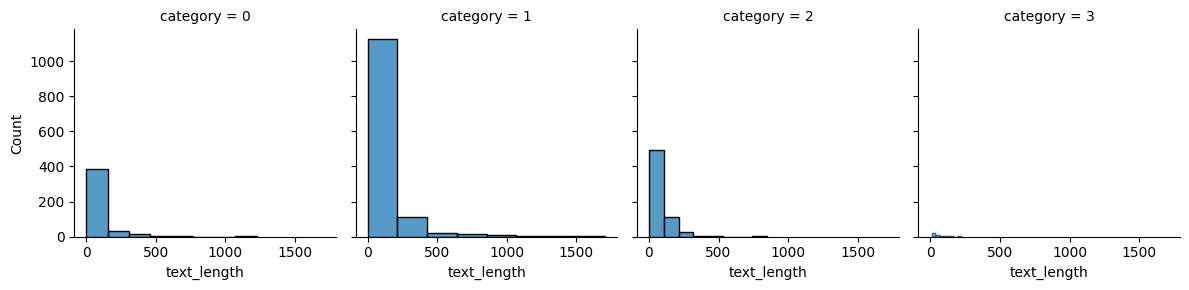

In [24]:
g = sns.FacetGrid(df_val,col='category')
g.map_dataframe(sns.histplot,x='text_length',bins=8)
plt.show()

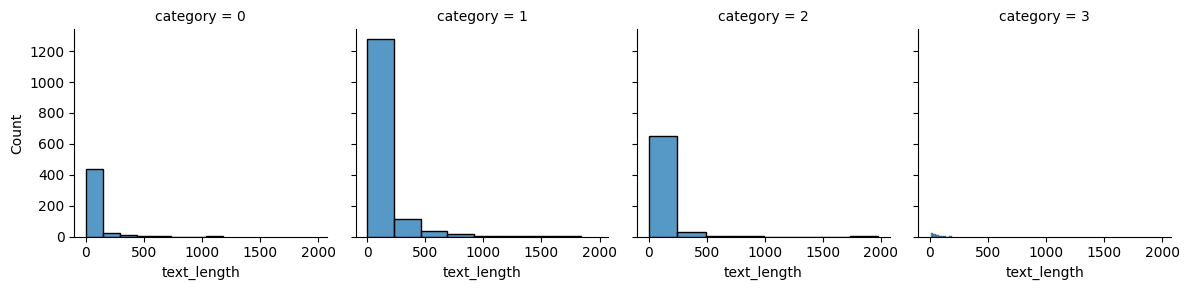

In [25]:
g = sns.FacetGrid(df_test,col='category')
g.map_dataframe(sns.histplot,x='text_length',bins=8)
plt.show()

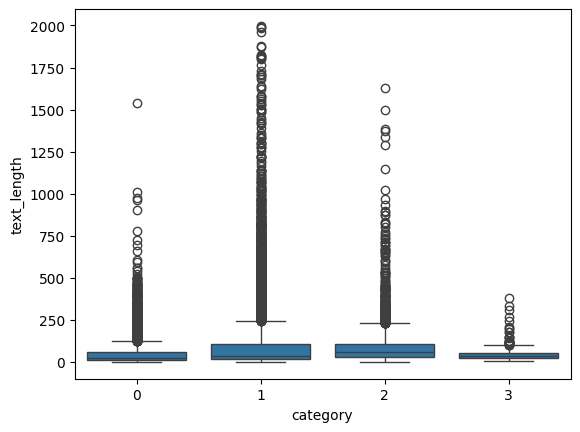

In [26]:
sns.boxplot(data=df_train,x='category',y='text_length')
plt.show()

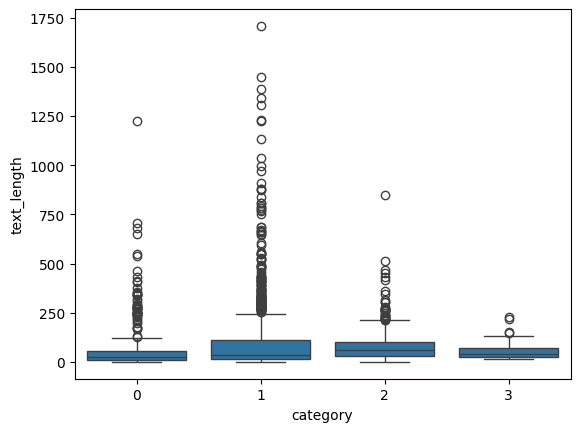

In [27]:
sns.boxplot(data=df_val,x='category',y='text_length')
plt.show()

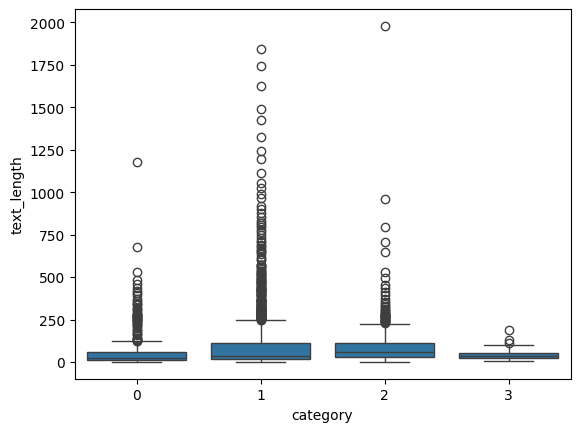

In [28]:
sns.boxplot(data=df_test,x='category',y='text_length')
plt.show()

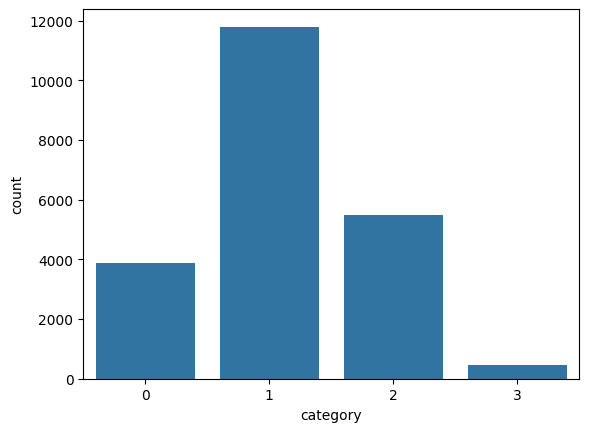

In [29]:
sns.countplot(data=df_train,x='category')
plt.show()

## Data Preprocessing

### Remove stopword and then tokenization

In [30]:
stopwords = list(thai_stopwords())
stopwords[:10]

['ช่วงต่อไป',
 'บอก',
 'พอเพียง',
 'กับ',
 'กล่าวคือ',
 'ทีๆ',
 'ช่วย',
 'อย่างหนึ่ง',
 'ค่อนข้างจะ',
 'ก็ตาม']

In [31]:
def text_preprocess(texts):
    cleaned_text = "".join(text for text in texts if text not in (".",";",":","!",'"',"ๆ","ฯ"))
    cleaned_text = word_tokenize(cleaned_text)
    cleaned_text = " ".join(word for word in cleaned_text)
    cleaned_text = " ".join(word for word in cleaned_text.split() if word.lower not in stopwords)
    return cleaned_text

In [32]:
df_train['texts_tokenized'] = df_train['texts'].apply(text_preprocess)
df_val['texts_tokenized'] = df_val['texts'].apply(text_preprocess)
df_test['texts_tokenized'] = df_test['texts'].apply(text_preprocess)

In [33]:
df_train.head()

,texts,category,text_length,texts_tokenized
0,ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกร...,1,162,ไป จอง มา แล้ วนา จา Mitsubishi Attrage ได้ หล...
1,เปิดศักราชใหม่! นายกฯ แถลงข่าวก่อนการแข่งขันศึ...,1,75,เปิด ศักราช ใหม่ นายก แถลงข่าว ก่อน การแข่งขัน...
2,บัตรสมาชิกลดได้อีกไหมคับ,1,24,บัตรสมาชิก ลด ได้ อีก ไหม คับ
3,สนใจ new mazda2ครับ,1,19,สนใจ new mazda 2 ครับ
4,😍😍,0,2,😍😍


In [34]:
df_val.head()

,texts,category,text_length,texts_tokenized
0,วันที่6/3/61 เสียอารมณ์มาเร้ย. อาหารช้ามากกกกก...,2,147,วันที่ 6 /3/61 เสียอารมณ์ มา เร้ย อาหาร ช้า มา...
1,ยี่ห้อนี่ เขาชอบตั้งชื่อ ลงท้ายด้วย สระอา เทีย...,0,93,ยี่ห้อ นี่ เขา ชอบ ตั้งชื่อ ลงท้าย ด้วย สระ อา...
2,สองวันสุดท้าย! ใครอยู่แถวแฟชั่น ไอส์แลนด์ มาร่...,1,371,สอง วันสุดท้าย ใคร อยู่ แถว แฟชั่น ไอส์แลนด์ ม...
3,น้องแสงโสมอี้บ๋อ กะว่าน้องโซดา น้ำแข็งดี เอ๊ะห...,0,85,น้อง แสงโสม อี้ บ๋อ กะ ว่า น้อง โซดา น้ำแข็ง ด...
4,สนามบินไหนไม่แพงล่ะครับบ ชางฮี เชคแลบก๊ก เจเอฟ...,1,555,สนามบิน ไหน ไม่ แพง ล่ะ ครับ บ ชา ง ฮี เชค แลบ...


In [35]:
df_test.head()

,texts,category,text_length,texts_tokenized
0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...,2,51,ซื้อ แต่ ผ้าอนามัย แบบ เย็น มา ค่ะ แบบ ว่า อี ...
1,ครับ #phithanbkk,1,16,ครับ #phithanbkk
2,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...,2,82,การ ด่า ไป เหมือน ได้ บรรเทา ความเครียด เฉย แต...
3,Cf clarins 5 ขวด 2850,1,21,Cf clarins 5 ขวด 2850
4,ทานได้ค่ะ น้ำซุป MK ต้มมาจากหัวผักกาด ซีอิ้วขา...,1,65,ทาน ได้ ค่ะ น้ำ ซุป MK ต้ม มาจาก หัวผักกาด ซีอ...


### Check frequency of word

Word Cloud of Positive word in training dataset

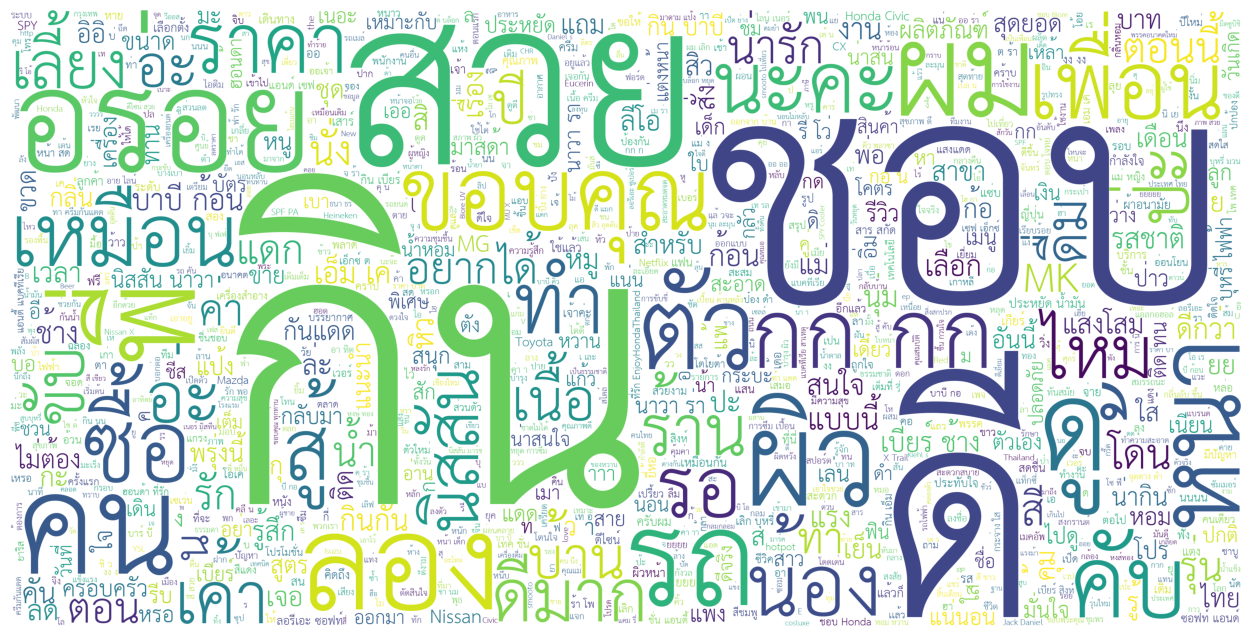

In [36]:
df_pos = df_train[df_train['category'] == 0]
pos_words = " ".join(text for text in df_pos['texts_tokenized'])
regex_pattern =  r"[ก-๙a-zA-Z0-9]+"   
font = 'THSarabunNew.ttf'

wordcloud = WordCloud(stopwords=stopwords,background_color='white',font_path=font,max_words=1000,
                      width=4000,height=2000,regexp=regex_pattern).generate(pos_words)

plt.figure(figsize = (16,8))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


Word Cloud of Negative word in training dataset

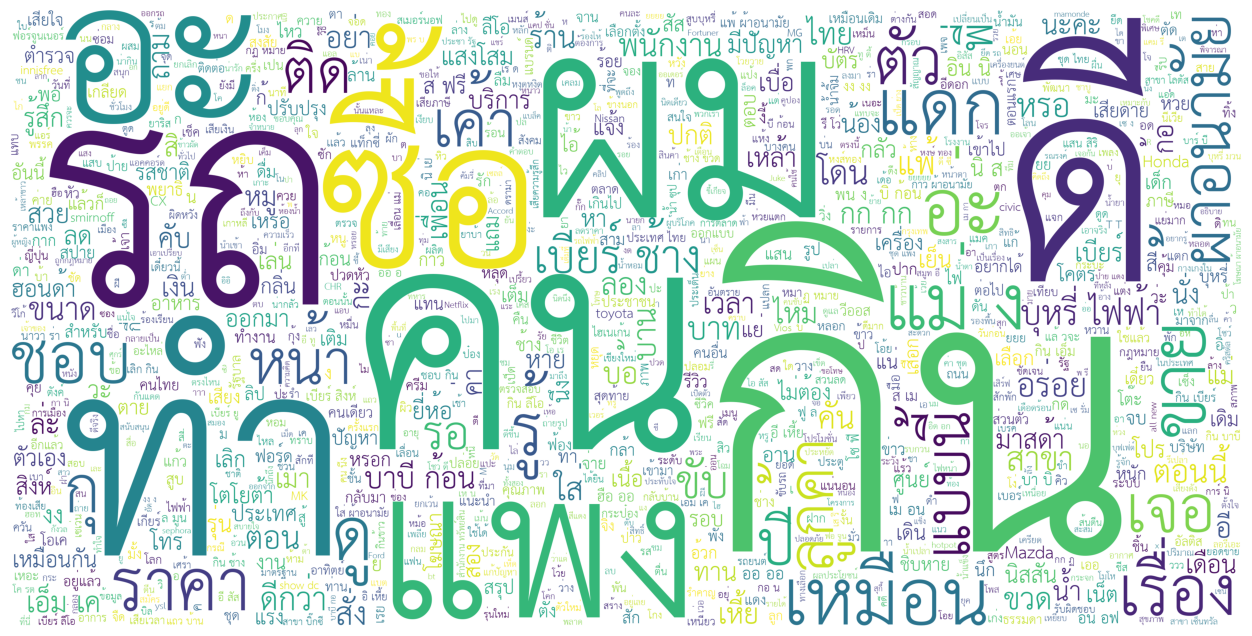

In [37]:
df_pos = df_train[df_train['category'] == 2]
neg_words = " ".join(text for text in df_pos['texts_tokenized'])
regex_pattern =  r"[ก-๙a-zA-Z0-9]+"        
font = 'THSarabunNew.ttf'

wordcloud = WordCloud(stopwords=stopwords,background_color='white',font_path=font,max_words=1000,
                      width=4000,height=2000,regexp=regex_pattern).generate(neg_words)

plt.figure(figsize = (16,8))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


# Logistic Regression Method

### Prepare data with Tfidf and process_thai

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pythainlp.ulmfit import process_thai
tfidf = TfidfVectorizer(tokenizer=process_thai, ngram_range=(1,2), min_df=20, sublinear_tf=True)
tfidf_fit = tfidf.fit(df_train["texts"])
X_train = tfidf_fit.transform(df_train["texts"])
X_valid = tfidf_fit.transform(df_val["texts"])
X_test = tfidf_fit.transform(df_test["texts"])

y_train = df_train['category']
y_val = df_val['category']
y_test = df_test['category']

C:\Users\Phattaradanai\anaconda3\envs\tenserflowgpu\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [90]:
#test with logistic regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train,y_train)
model.score(X_valid,y_val)

C:\Users\Phattaradanai\anaconda3\envs\tenserflowgpu\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.7084026622296173

In [40]:
predictions= model.predict(X_test)

In [41]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.65      0.35      0.45       478
           1       0.71      0.87      0.78      1453
           2       0.75      0.68      0.71       683
           3       0.83      0.09      0.16        57

    accuracy                           0.71      2671
   macro avg       0.73      0.50      0.53      2671
weighted avg       0.71      0.71      0.69      2671



## Save model

# LSTM Method

### Padding sequences

In [42]:
from keras.utils import to_categorical
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_train["texts_tokenized"])

train_sequences = tokenizer.texts_to_sequences(df_train["texts_tokenized"])
val_sequences = tokenizer.texts_to_sequences(df_val["texts_tokenized"])
test_sequences = tokenizer.texts_to_sequences(df_test["texts_tokenized"])

X_train = pad_sequences(train_sequences, maxlen=2000)
X_val = pad_sequences(val_sequences, maxlen=2000)
X_test = pad_sequences(test_sequences, maxlen=2000)

y_train = to_categorical(df_train['category'], num_classes=4)
y_val = to_categorical(df_val['category'], num_classes=4)
y_test = to_categorical(df_test['category'], num_classes=4)


## Create LSTM Model

In [43]:
model = Sequential()
model.add(Embedding(input_dim=5000,output_dim=1024,input_length=2000))
#model.add(Dropout(0.4))
model.add(LSTM(128,dropout=0.4))
model.add(Dense(4,activation='softmax'))


In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 1024)        5120000   
                                                                 
 lstm (LSTM)                 (None, 128)               590336    
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 5,710,852
Trainable params: 5,710,852
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [46]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

In [47]:
history = model.fit(X_train,y_train,
              validation_data = (X_val,y_val),
              epochs=10,
              callbacks=[early_stop],
            )

Epoch 1/10
676/676 [==============================] - 174s 254ms/step - loss: 0.8063 - accuracy: 0.6703 - val_loss: 0.7217 - val_accuracy: 0.7013
Epoch 2/10
676/676 [==============================] - 173s 256ms/step - loss: 0.6101 - accuracy: 0.7523 - val_loss: 0.7358 - val_accuracy: 0.7030
Epoch 3/10
676/676 [==============================] - 174s 258ms/step - loss: 0.4981 - accuracy: 0.7981 - val_loss: 0.7612 - val_accuracy: 0.7030
Epoch 4/10
676/676 [==============================] - 174s 258ms/step - loss: 0.4049 - accuracy: 0.8354 - val_loss: 0.8669 - val_accuracy: 0.6980
Epoch 5/10
676/676 [==============================] - 174s 258ms/step - loss: 0.3253 - accuracy: 0.8696 - val_loss: 0.9845 - val_accuracy: 0.6938
Epoch 5: early stopping


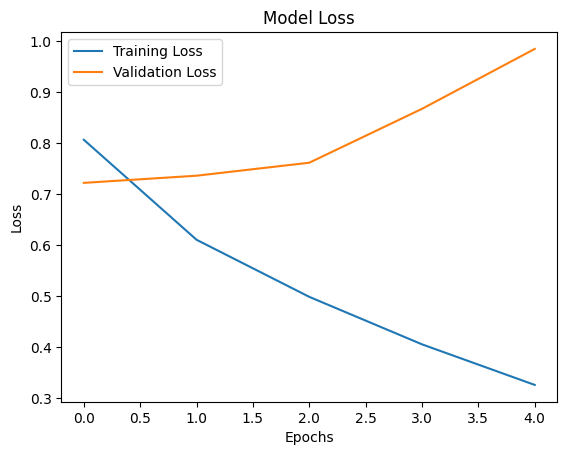

In [49]:
model_loss = pd.DataFrame(model.history.history)

plt.plot(model_loss['loss'], label='Training Loss')
plt.plot(model_loss['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

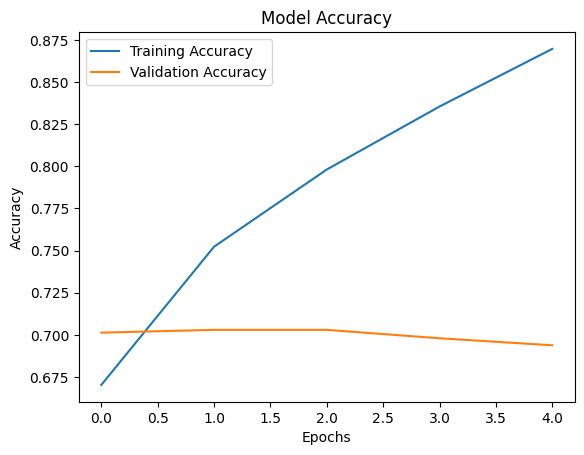

In [50]:
plt.plot(model_loss['accuracy'], label='Training Accuracy')
plt.plot(model_loss['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [51]:
predictions = model.predict(X_test)

84/84 [==============================] - 8s 90ms/step


## Evaluate model

In [52]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.57      0.41      0.48       478
           1       0.73      0.78      0.75      1453
           2       0.69      0.73      0.71       683
           3       0.33      0.30      0.31        57

    accuracy                           0.69      2671
   macro avg       0.58      0.55      0.56      2671
weighted avg       0.68      0.69      0.68      2671



## Save model

In [53]:
model.save('lstm_model.h5')

## Testing Model with some input

In [54]:
sentiment_labels = {
    0: 'Positive',
    1: 'Neutral',
    2: 'Negative',
    3: 'Question',
    # Add more labels if you have additional classes
}

def predict_sentiment(review):
    #tokenize and pad
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence,maxlen=2000)
    prediction = model.predict(padded_sequence)
    sentiment_index = np.argmax(prediction)
    sentiment = sentiment_labels.get(sentiment_index)

    return sentiment

In [83]:
predict_sentiment('ชอบกินอะอร่อยดี')

1/1 [==============================] - 0s 62ms/step


'Neutral'

In [85]:
predict_sentiment('โครตไม่ชอบอันนี้เลย แย่มาก')

1/1 [==============================] - 0s 61ms/step


'Negative'

In [86]:
predict_sentiment('ฟินมากมีความสุขสุดๆเลยวันนี้')

1/1 [==============================] - 0s 59ms/step


'Neutral'

# Conclusion

The current models exhibit slightly low accuracy, which can be attributed to the complexities of processing social media content in the Thai language, as well as instances of overfitting. To address these issues, I recommend implementing hyperparameter tuning, along with the incorporation of dropout and regularization techniques, to enhance model accuracy.